In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# deeptrack.features

This notebook introduces the module deeptrack.features.

## 1. What is a feature?

Features are instances of the abstract class `Feature` and are responsible for creating and altering images. For example, a feature might add the image of a particle or add some salt-and-pepper noise.

All features operate on lists of images. Most features, such as noise, apply some tranformation to all images in the list. This transformation can be additive, such as adding some Gaussian noise or a background illumination, or non-additive, such as introducing Poisson noise or performing a low-pass filter. This transformation is defined by the method `get(image, **kwargs)`, which all implementations of the class `Feature` need to define.

Some features, for example scattterers, instead, append a new image to the list. To control this behaviour, one can set the class attributes `__distributed__` and `__list_merge_strategy__`:
* `__distributed__` controls if `.get(image, **kwargs)` is called on each element in the list separately (`__distributed__ = True`), or if the list is sent passed as a whole (`__distributed__ = False`).  
* `__list_merge_strategy__` defines how the output of `.get(image, **kwargs)` is merged with the input list. It can be `MERGE_STRATEGY_OVERRIDE` (0, default), where the new list is outputted without merging with the input, or `MERGE_STRATEGY_APPEND` (1), where the new list is appended to the end of the input. 

When a feature is created, keyword arguments can be passed to its constructor. These arguments are stored as properties (as a PropertyDict) of the feature (see also [properties_example](properties_example.ipynb)), which determine how the feature is resolved. When a feature is updated using the method `.update()`, all properties are updated as well by calling their respective methods `.update()`. When a feature is resolved using the method `resolve(image)`, the current values of all properties are sent through the method `get(image, **kwargs)` as keyword arguments.

In [3]:
import numpy as np
from deeptrack.features import Feature

# Implementation of abstract class Feature 
# which does not alter the input image 
# and prints the current value of my_property
class Foo(Feature):

    # Controls what is passed to the method get(): 
    # False: everything is passed without modification.
    # True: elements along the first axis are passed separately.
    __distributed__ = False

    def get(self, image, my_property=None, **kwargs):
        print("The current value of my_property is", my_property)
        return image



foo1 = Foo(my_property=1)
output_image = foo1.resolve()

foo2 = Foo(my_property="bar")
output_image = foo2.resolve()

foo3 = Foo()
output_image = foo3.resolve()

The current value of my_property is 1
The current value of my_property is bar
The current value of my_property is None


Since the values are stored as instances of the class `Property`, we can always replace values with standard structures (e.g., lists or lambda functions) to create more complex behaviors (see also [properties_example](properties_example.ipynb)).

In [4]:
foo4 = Foo(my_property=lambda: np.random.rand() - 0.5)
output_image = foo4.resolve()

foo5 = Foo(my_property=["bar", "baz"]) # picks one random element from the list
output_image = foo5.resolve()

The current value of my_property is 0.2193063105090347
The current value of my_property is ['bar', 'baz']


## 2. Operations defined on features

Features can be combined to create a feature series, which is a series of features that are evaluated sequentially. This is done using the add operator (+), the multiply operator (\*), and the power operator (\*\*).

### Adding features (+)

The add operator (+) combines two features such that they are evaluated sequentially. For example, given the features `foo` and `bar`, we can combine them as `foobar = foo + bar`. When `foobar` resolves an image, it first resolves an image from `foo`, then uses this image as the input to resolve an image from `bar`.

This operation returns an instance of `Branch`, which contains the two features.

In [5]:
foobar = Foo(my_property="foo") + Foo(my_property="bar")

output_image = foobar.resolve()

The current value of my_property is foo
The current value of my_property is bar


### Multiplying a feature by a number (\*)

Multiplying a feature `foo` by a number `p` creates a new feature that has a probability `p` of resolving the feature `foo`, and a probability `1-p` to return the input image without modifying it.

This operation returns an instance of `Probability`, which contains the feature and the probability to resolve the feature.

In [6]:
foo = Foo(my_property=0) * 0.5

output_image = foo.resolve() # if the feature is not resolved, nothing is printed

And now a more complex example combining addition and multiplication.

In [7]:
foo = Foo(my_property=0) * 0.5
for i in range(1, 10):
    foo = foo + Foo(my_property=i) * 0.5
# foo is now 10 instances of Foo, each with a 50 % chance of being resolved.
    
output_image = foo.resolve()

The current value of my_property is 0
The current value of my_property is 1
The current value of my_property is 2
The current value of my_property is 3
The current value of my_property is 4
The current value of my_property is 5
The current value of my_property is 7
The current value of my_property is 8
The current value of my_property is 9


### Exponentiating feature to integer (\*\*)

The power operator (\*\*) takes a feature `foo` and an integer `i` and creates `i` deep copies of the feature, which are added to the feature series at resolve time. For example, `foo**5` will create 5 deep copies of the instance of Foo and add them to the feature series. Since this is done at resolve time, the exponent can be any expression that returns an integer when sampled.

This operation returns an instance of `Duplicate`, which contains the original feature and the number of times it should be duplicated.

In [8]:
foo = Foo(my_property=lambda: np.random.choice(["bar", "baz", "qux", "quux"])) 

output_image = (foo**5).resolve()

The current value of my_property is bar
The current value of my_property is bar
The current value of my_property is qux
The current value of my_property is quux
The current value of my_property is bar


In [9]:
number_of_foo = np.random.randint(0, 10)
output_image = (foo**number_of_foo).resolve() # picks one random exponent from the list

The current value of my_property is quux
The current value of my_property is bar
The current value of my_property is bar
The current value of my_property is bar
The current value of my_property is quux
The current value of my_property is qux
The current value of my_property is qux
The current value of my_property is qux
The current value of my_property is bar


## 3. Example - Image with random circles

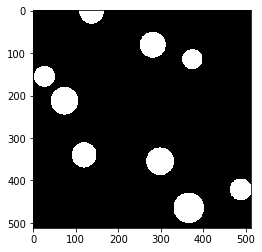

In [12]:
# Implementation of the abstract class Feature that draws a circle on an image.
class Circle(Feature):

    def get(self, image, position=None, radius=None, intensity=None, **kwargs):
        X, Y = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))
        mask = (X - position[0])**2 + (Y - position[1])**2 < radius**2
        image[mask] = intensity
        return image

circle = Circle(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + np.random.rand() * 20,
    intensity=1
)

input_image = np.zeros((512, 512))

output_image = (circle**10).resolve(input_image) 

from matplotlib import pyplot as plt
plt.imshow(output_image, cmap='gray')
plt.show()

## 4. Example - Image with stacked circles

It's not unusual for a feature to depend on some other feature. Due to the way features are updated, we can only reliably depend on features that are resolved earlier in the sequence. 

Since the Duplicate feature (produced by the \*\* operator) resolves deep copies of the original feature, it should not be used on dependent features. As an example, consider `C = (A + B) ** 3`. This operation will produce three copies of A (A1, A2, A3), and three copies of B (B1, B2, B3). If B depends on A, then (B1, B2, B3) will also depend on A, not (A1, A2, A3) as one might expect.

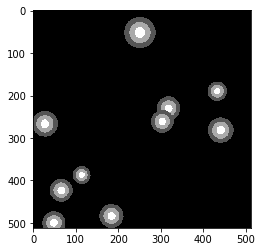

In [13]:
# Due to Python scoping rules, we need to move this evaluation to its own scope. 
# This is why we use wrapped function instead of lambda functions.
def get_position(base):
    def func():
        return base.properties["position"].current_value
    return func

def get_radius(base, multiplication_factor):
    def func():
        return base.properties["radius"].current_value * multiplication_factor
    return func

# Since 'circle2' references the instance 'circle1', we can't use the ** syntax
# to duplicate the feature. Instead we use a for-loop.
for i in range(10):
    
    circle1 = Circle(
        position=lambda: np.random.rand(2) * 512,
        radius=lambda: 20 + np.random.rand() * 20,
        intensity=1
    )
   
    circle2 = Circle(
        position=get_position(circle1),
        radius=get_radius(circle1, 0.67),
        intensity=2
    )

    circle3 = Circle(
        position=get_position(circle1),
        radius=get_radius(circle1, 0.33),
        intensity=3
    )
    
    stacked_circles = circle1 + circle2 + circle3
    
    if i == 0:
        features = stacked_circles
    else: 
        features = features + stacked_circles
        
input_image = np.zeros((512, 512))
output_image = features.resolve(input_image) 

from matplotlib import pyplot as plt
plt.imshow(output_image, cmap='gray')
plt.show()

## 5. Example - Image with power-operator-friendly stacked circles 

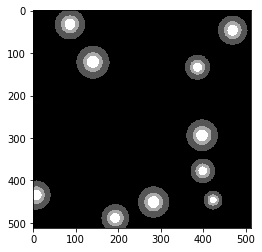

In [15]:
# We create a new Feature subclass that takes a list of features and
# updates the position and radius values of every feature in the list
# before resolving them.
class StackedCircles(Feature):
    
    def get(self, image, position=None, radius=None, circle_list=None, **kwargs):
        
        for circle in circle_list:
            circle.properties["position"].current_value = position
            circle.properties["radius"].current_value = radius
            
            radius *= 0.60
            image = circle.resolve(image)
            
        return image

    
circle1 = Circle(
    position=None,
    radius=None,
    intensity=1
)

circle2 = Circle(
    position=None,
    radius=None,
    intensity=2
)

circle3 = Circle(
    position=None,
    radius=None,
    intensity=3
)

stacked_circles = StackedCircles(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + 20 * np.random.rand(),
    circle_list=lambda: [circle1, circle2, circle3]
)

input_image = np.zeros((512, 512))
output_image = (stacked_circles**10).resolve(input_image) 

from matplotlib import pyplot as plt
plt.imshow(output_image, cmap='gray')
plt.show()

## 6. Example - Image with random non-overlapping circles

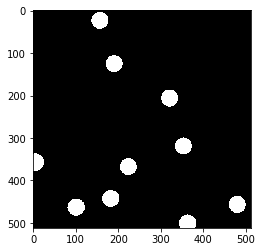

In [16]:
# Function that returns a position that is atleast 2 * radius away from every other
# circle in the parameter `previous`.
def NonOverlappingPosition(previous_circles, position_function, radius):
    def func():
        
        previous_positions = [circle.properties["position"].current_value for circle in previous_circles]

        overlapping = True
        while overlapping:
            position = position_function()
            overlapping = any(
                [
                np.sum((position - previous_position)**2) < radius**2 * 2 
                for previous_position in previous_positions
                ]
            )
        return position
    return func
            
RADIUS = 20 # Fixed radius since accessing properties of self is more difficult.

circles = []
for i in range(10):
    # Create the circle instance
    circle = Circle(
        position=NonOverlappingPosition(circles[:], lambda: np.random.rand(2) * 512, RADIUS),
        radius=RADIUS,
        intensity=1
    )
    circles.append(circle)
    
    if i == 0:
        circle_features = circle
    else:
        circle_features = circle_features + circle


input_image = np.zeros((512, 512))
output_image = circle_features.resolve(input_image) 

from matplotlib import pyplot as plt
plt.imshow(output_image, cmap='gray')
plt.show()